## 1. Fundamentos de K-Means

Imaginemos que colocamos K “chinchetas” (centroides) sobre el mapa de nuestros datos. Veremos que:
- Cada punto “elige” la chincheta más cercana.
- Luego movemos cada chincheta al promedio de sus puntos.
- Repetimos (re-asignar y mover) hasta que apenas cambien.

¿Para qué lo usamos? Para agrupar datos en K grupos similares cuando no tenemos etiquetas.

## 2. Modelo matemático

Pensemos que queremos que cada punto quede lo más cerca posible del centro de su grupo. En términos sencillos, K-Means minimiza la inercia (suma de distancias cuadráticas dentro de cada clúster):

$$
J = \sum_{k=1}^{K} \sum_{i \in C_k} ||x_i - \mu_k||^2
$$

Cuanto más pequeño es $J$, más compactos están los clústeres.

## 3. Librería que usaremos

Usaremos `scikit-learn`. Veremos y usaremos:
- `load_iris`: 150 muestras de 3 especies de flores (4 características). Elegimos K=3 por sentido común.
- `KMeans`: parámetros clave `n_clusters`, `init='k-means++'`, `n_init` (≥10), `random_state`.
- Métricas: `silhouette_score` y `davies_bouldin_score` (sin etiquetas), `adjusted_rand_score` y `v_measure_score` (con etiquetas, sin importar el orden de clústeres).

In [1]:
%pip install numpy pandas matplotlib scikit-learn seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    v_measure_score,
)
import warnings

# Configuración de visualización
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## 4. Pipeline con Iris

Veremos el flujo completo: cargamos los datos, los escalamos (opcional), entrenamos K-Means, predecimos y evaluamos.

In [3]:
# Cargar el dataset Iris
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data  # 4 características
y = iris.target  # 3 especies
feature_names = iris.feature_names

# Escalado (opcional pero recomendable si las unidades difieren)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Forma de los datos (X): {X.shape}")
print(f"Forma de las etiquetas (y): {y.shape}")
print(f"Clases (especies): {iris.target_names}")

Forma de los datos (X): (150, 4)
Forma de las etiquetas (y): (150,)
Clases (especies): ['setosa' 'versicolor' 'virginica']


### 4.1 Preprocesamiento

Veremos estadísticas básicas y una proyección PCA para visualizar las 3 especies.

In [4]:
# DataFrame para análisis rápido
df = pd.DataFrame(X, columns=feature_names)
df['species_id'] = y

print("Estadísticas descriptivas:")
print(df[feature_names].describe())

Estadísticas descriptivas:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


#### Proyección PCA para visualización
Usaremos PCA a 2 componentes para visualizar los datos en 2D y colorear por especie real.

¿Qué son PC1 y PC2?
- PCA (Análisis de Componentes Principales) crea nuevas variables (componentes) combinando las características originales.
- PC1 es la dirección que captura la mayor variación posible.
- PC2 es la segunda dirección, independiente (ortogonal) de PC1.

¿Por qué lo usamos?
- Pasamos de 4 variables a 2 para “ver” la estructura.
- Si ciertas especies forman grupos, K-Means suele capturarlos.

Importante: PC1 y PC2 no son variables originales, sino combinaciones de ellas (un “mapa comprimido”).

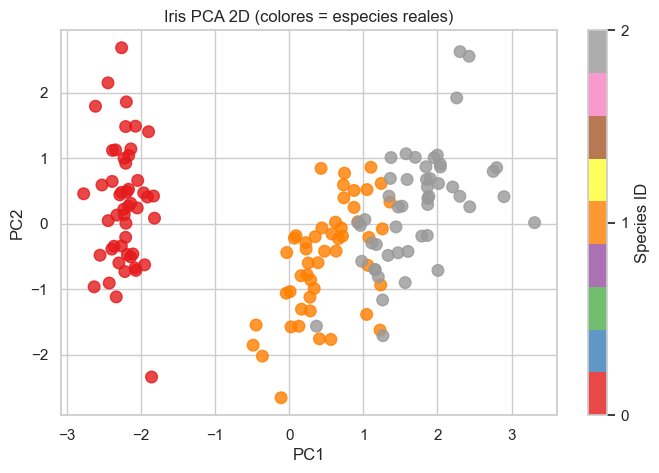

In [5]:
# PCA 2D coloreado por especie
pca_vis = PCA(n_components=2, random_state=42)
X_pca2 = pca_vis.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
scatter = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='Set1', s=70, alpha=0.8)
plt.title('Iris PCA 2D (colores = especies reales)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, ticks=range(3), label='Species ID')
plt.show()

### 4.2 Entrenamiento del modelo

Entrenemos K-Means. Elegimos K=3 (Setosa, Versicolor, Virginica) y fijamos `random_state` para reproducibilidad.

In [6]:
# KMeans con K=3 (especies)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)

# Entrenar con X escalado (recomendado)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("¡Modelo K-Means entrenado para Iris!")
print(f"Primeras 20 etiquetas de clúster: {cluster_labels[:20]}")
print("Centroides (forma):", centroids.shape)

¡Modelo K-Means entrenado para Iris!
Primeras 20 etiquetas de clúster: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Centroides (forma): (3, 4)


### 4.3 Predicción

Función para asignar una nueva flor (vector de 4 medidas) a un clúster.

In [7]:
def predecir_cluster(patron, modelo_kmeans, scaler=None):
    """
    Recibe un patrón (array de 4 características en Iris) y un modelo KMeans entrenado,
    y devuelve el ID del clúster predicho.
    """
    patron = np.array(patron).reshape(1, -1)
    if scaler is not None:
        patron = scaler.transform(patron)
    return int(modelo_kmeans.predict(patron)[0])

# Prueba con dos ejemplos del dataset
patron_nuevo_1 = X[0]
print("Ejemplo 0 → clúster:", predecir_cluster(patron_nuevo_1, kmeans, scaler))

patron_nuevo_2 = X[100]
print("Ejemplo 100 → clúster:", predecir_cluster(patron_nuevo_2, kmeans, scaler))

Ejemplo 0 → clúster: 1
Ejemplo 100 → clúster: 2


### 4.4 Evaluación del modelo

Relación de clústeres con especies reales. Como los IDs de clúster son arbitrarios, aplicamos un mapeo óptimo (algoritmo Húngaro) para interpretar y medir.

In [8]:
ct = pd.crosstab(y, cluster_labels)
print("Tabla Cruzada (Real vs. Clúster):")
print(ct)

Tabla Cruzada (Real vs. Clúster):
col_0   0   1   2
row_0            
0       0  50   0
1      39   0  11
2      14   0  36


**Interpretación de la Tabla Cruzada:**

- No existe una correspondencia fija entre índices de clúster y especies reales.
- Observa qué especie se concentra más en cada columna (clúster) para intuir la asignación.
- En el siguiente paso aplicaremos un mapeo óptimo clúster→etiqueta para evaluar con una matriz de confusión interpretable.

In [9]:
# Mapeo óptimo clúster→etiqueta con algoritmo Húngaro
from scipy.optimize import linear_sum_assignment

cm_raw = confusion_matrix(y, cluster_labels)
# Convertimos a problema de minimización
cost = cm_raw.max() - cm_raw
r_ind, c_ind = linear_sum_assignment(cost)
# mapping: clúster -> etiqueta real
mapping = {c: r for r, c in zip(r_ind, c_ind)}

mapped_labels = np.vectorize(mapping.get)(cluster_labels)
print("Mapeo clúster→etiqueta (clúster: etiqueta):", mapping)

Mapeo clúster→etiqueta (clúster: etiqueta): {np.int64(1): np.int64(0), np.int64(0): np.int64(1), np.int64(2): np.int64(2)}


#### Matriz de Confusión
La matriz de confusión nos permite ver en detalle cuántas predicciones fueron correctas y cuántas incorrectas, y de qué tipo.

Matriz de Confusión:
[[50  0  0]
 [ 0 39 11]
 [ 0 14 36]]


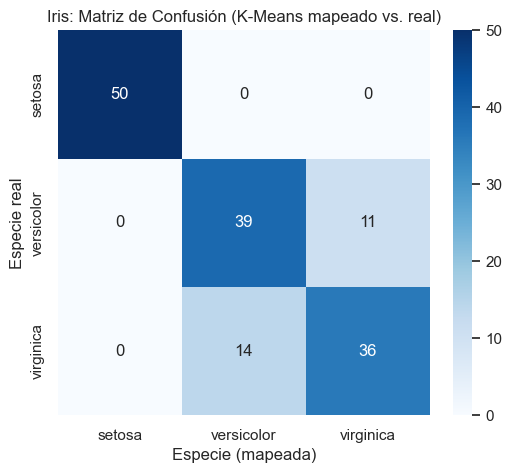

In [10]:
# Matriz de confusión con etiquetas mapeadas
cm = confusion_matrix(y, mapped_labels)
print("Matriz de Confusión:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.title('Iris: Matriz de Confusión (K-Means mapeado vs. real)')
plt.ylabel('Especie real')
plt.xlabel('Especie (mapeada)')
plt.show()

**Interpretación de la Matriz:**
- Diagonal: aciertos (especie real coincide con la mapeada).
- Fuera de la diagonal: confusiones (p. ej., Versicolor vs Virginica).

#### Accuracy (Exactitud)
El Accuracy nos da el porcentaje total de muestras correctamente agrupadas tras realizar el mapeo clúster→etiqueta.

In [11]:
# Calcular el Accuracy tras el mapeo óptimo
acc = accuracy_score(y, mapped_labels)
print(f"Accuracy del modelo K-Means (con mapeo): {acc * 100:.2f}%")

Accuracy del modelo K-Means (con mapeo): 83.33%


**Interpretación del Accuracy:**
Refleja qué proporción de flores fueron agrupadas en el clúster que mejor corresponde a su especie tras el mapeo. Los errores suelen ocurrir entre Versicolor y Virginica porque son morfológicamente más parecidas.

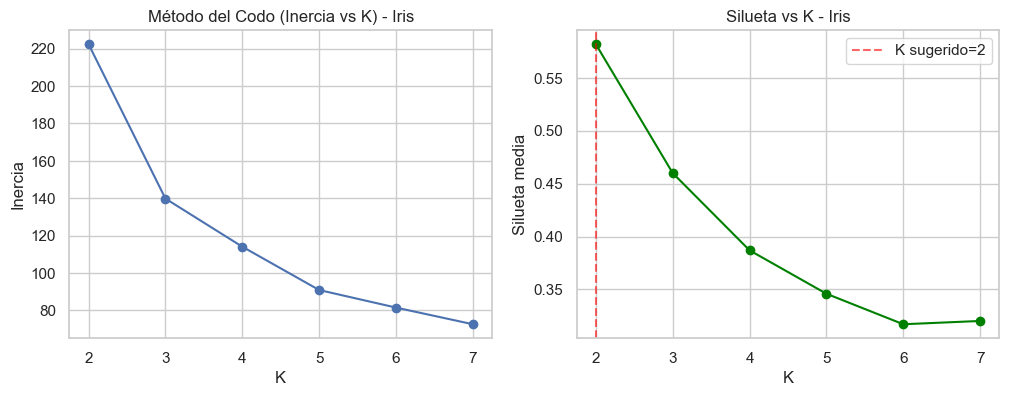

K sugerido por silueta en Iris (escalado): 2


In [12]:
# Elbow y Silhouette en Iris (con escalado)

Ks = range(2, 8)
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

best_k_sil = Ks[int(np.argmax(np.array(sil_scores)))]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(Ks, inertias, marker='o')
ax[0].set_title('Método del Codo (Inercia vs K) - Iris')
ax[0].set_xlabel('K')
ax[0].set_ylabel('Inercia')

ax[1].plot(Ks, sil_scores, marker='o', color='green')
ax[1].set_title('Silueta vs K - Iris')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Silueta media')
ax[1].axvline(best_k_sil, color='red', linestyle='--', alpha=0.6, label=f'K sugerido={best_k_sil}')
ax[1].legend()

plt.show()
print(f"K sugerido por silueta en Iris (escalado): {best_k_sil}")

## 5. ¿Cómo elegir K?

Cuando no lo sabemos de antemano, elegimos K con heurísticas:
- Elbow (Codo): veremos dónde la inercia deja de bajar “en serio”.
- Silhouette: probemos distintos K y nos quedamos con el que dé silueta más alta.

Consejo: escalemos siempre antes de K-Means.

### 5.1 ¿Por qué K=3 en Iris?

- Conocimiento del dominio: Iris tiene 3 especies (Setosa, Versicolor, Virginica), por lo que K=3 es una hipótesis natural cuando queremos aproximar esas especies.
- Heurísticas sin etiquetas:
  - El codo en inercia suele mostrar un cambio de pendiente cerca de K≈3, lo que sugiere rendimientos decrecientes más allá de 3.
  - Silhouette y Davies-Bouldin, en Iris, a menudo favorecen K=2. Razón: Setosa forma un grupo muy compacto y bien separado, mientras que Versicolor y Virginica se solapan; con K=2, el algoritmo separa “Setosa vs. las otras”.
- Con etiquetas (validación supervisada para entender el comportamiento):
  - ARI suele ser mayor en K=3 que en K=2 (mejor correspondencia con las 3 especies).
  - V-Measure puede quedar similar o incluso ligeramente mayor en K=2 dependiendo de la inicialización/escalado.

Conclusión práctica:
- Si el objetivo es descubrir la estructura más separada sin etiquetas, K=2 puede aparecer como óptimo según Silhouette/DB.
- Si el objetivo es aproximar las 3 especies reales, K=3 es la elección coherente con el dominio, aceptando el solapamiento entre Versicolor y Virginica.

Nota:
- ARI y V-Measure son invariantes a la permutación de etiquetas. Para seleccionar K sin etiquetas, prioriza Silhouette/DB y el contexto del problema; usa ARI/V-Measure solo como verificación cuando existan etiquetas de referencia.

In [13]:
# Comparación de K en {2,3,4,5}: inercia, silhouette, DB, ARI, V-Measure
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, v_measure_score

Ks_compare = [2, 3, 4, 5]
rows = []
for k in Ks_compare:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    labels = km.labels_

    inertia = km.inertia_
    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    # Métricas con verdad-terreno (invariantes a permutación de etiquetas)
    ari = adjusted_rand_score(y, labels)
    v = v_measure_score(y, labels)

    rows.append({
        'K': k,
        'Inercia': inertia,
        'Silhouette': sil,
        'DaviesBouldin': db,
        'ARI': ari,
        'V-Measure': v,
    })

comp_k = pd.DataFrame(rows).set_index('K').round(4)
display(comp_k)

best_by_sil = comp_k['Silhouette'].idxmax()
best_by_db = comp_k['DaviesBouldin'].idxmin()
print(f"Mejor K por Silhouette: {best_by_sil}")
print(f"Mejor K por Davies-Bouldin (más bajo es mejor): {best_by_db}")

,Inercia,Silhouette,DaviesBouldin,ARI,V-Measure
K,,,,,
2,222.3617,0.5818,0.5933,0.5681,0.7337
3,139.8205,0.4599,0.8336,0.6201,0.6595
4,114.0925,0.3869,0.8698,0.4728,0.5973
5,90.9275,0.3459,0.9483,0.4348,0.6154


Mejor K por Silhouette: 2
Mejor K por Davies-Bouldin (más bajo es mejor): 2


## 6. Resultado final – en una mirada

Verás dos vistas PCA 2D:
- Izquierda: colores por clúster (K-Means) con centroides.
- Derecha: colores por especie real.

Si las manchas de la izquierda se parecen a las de la derecha, el agrupamiento capturó bien la estructura.

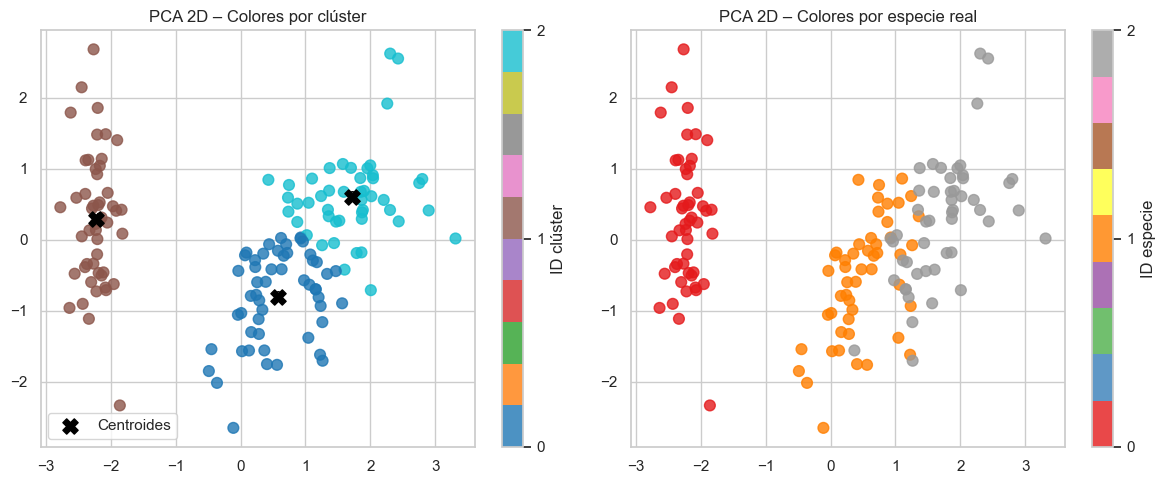

Tamaño de cada clúster:
0    53
1    50
2    47
Name: count, dtype: int64
Mayoría por clúster (aprox.): c0→1, c1→0, c2→2


In [14]:
# 6. Resultado final: comparación visual (clústeres vs especies)

# Asegurar PCA 2D
if 'X_pca2' not in globals():
    pca_vis = PCA(n_components=2, random_state=42)
    X_pca2 = pca_vis.fit_transform(X_scaled)
centroids_pca = pca_vis.transform(centroids)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Izquierda: colores por clúster
sc0 = ax[0].scatter(X_pca2[:,0], X_pca2[:,1], c=cluster_labels, cmap='tab10', s=60, alpha=0.8)
ax[0].scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=120, marker='X', label='Centroides')
for i, (xc, yc) in enumerate(centroids_pca):
    ax[0].text(xc, yc, str(i), color='black', fontsize=9, weight='bold', ha='center', va='center')
ax[0].set_title('PCA 2D – Colores por clúster')
ax[0].legend()

# Derecha: colores por especie real
sc1 = ax[1].scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='Set1', s=60, alpha=0.8)
ax[1].set_title('PCA 2D – Colores por especie real')

plt.colorbar(sc0, ax=ax[0], ticks=range(3), label='ID clúster')
plt.colorbar(sc1, ax=ax[1], ticks=range(3), label='ID especie')
plt.tight_layout()
plt.show()

# Resumen: tamaños y mapeo mayoritario
import pandas as pd
sizes = pd.Series(cluster_labels).value_counts().sort_index()
print('Tamaño de cada clúster:')
print(sizes)
mayoritarios = pd.crosstab(y, cluster_labels).idxmax(axis=0).to_dict()
print('Mayoría por clúster (aprox.):', ", ".join([f"c{c}→{d}" for c, d in sorted(mayoritarios.items())]))

## 7. Referencias bibliográficas

1. Scikit-learn (KMeans): https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
2. Evaluación de Clustering (Silhouette, Davies-Bouldin, etc.): https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
3. Dataset Iris: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
4. Silhouette Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html